In [1]:
from pyspark.context import SparkContext # required for reading input dataset. (Task 1)
import random # required for filling out random timestamp, if time column contains missing values (Task 4a)
import matplotlib.pyplot as plt # required for plotting. (Task 3.b)
import pandas as pd # required for plotting histograms. (Task 3.b)
import pyspark.sql.functions as F # required for aggregating columns & count for plotting histograms. (Task 3.b)
from pyspark.sql.functions import col, udf # col is required for renaming aggregated columns & count for plotting histograms. (Task 3.b) udf is required for counting tokens (Task 8.a)
from datetime import datetime # required for converting timestamp into categorical features. (Task 6)
from scipy.stats import kstest # required for normality test, using the Kolmogorov-Smirnov method (Task 7)
from pyspark.ml.feature import Tokenizer, RegexTokenizer # required for tokenization. (Task 8.a)
from pyspark.sql.types import IntegerType # required for counting tokens. (Task 8.a)
from pyspark.ml.feature import StopWordsRemover # required for removing stop words (Task 8.b)
from sklearn.feature_extraction.text import CountVectorizer # required for binary tokenization (Task 8.c)

# required for plotting. (Task 3.b)
%matplotlib inline

In [2]:
#=================
#Common variables:
#=================
numOfTopRecords = 10
minimalNumOfTopRecords = 3
numOfBinsInHistogramOfContinueosValues = 100

#=================
#Common functions:
#=================

# Get tupple of (minValue, maxValue) for column rdd.
# Parameters:
# - rdd: given rdd
# - index: index of the desired column in rdd.
def getMinMax(rdd, index):
    columnRdd = rdd.map(lambda x: int(x[index]))
    return (columnRdd.min(), columnRdd.max())

# Display the dash character ('-') for a given length times
def displayMultipleDashes(title, length):
    print('-' * length)

# Display title, with dash decoration
def displayTitle(title):
    length = len(title)
    print("\n")
    displayMultipleDashes(title, length)
    print(title)
    displayMultipleDashes(title, length)
    print("\n")
    
# Display title, with dash decoration
def displaySubTitle(title):
    length = len(title)
    print("\n")
    print(title)
    displayMultipleDashes(title, length)
    print("\n")

In [3]:
displayTitle("Task1:")

dataset = "Reviews.csv"

# Raise an error if dataset does not exist
# The dataset can be downloaded from this url: https://www.kaggle.com/qwikfix/amazon-recommendation-dataset/data
# The expected path of the dataset, should be in the same directory of this jupyter notebook file.
if not os.path.exists(dataset):
    raise ValueError('Dataset %s does not exist' % dataset)

print("Load the data")
reviews = sc.textFile(dataset)

print("extract header")
header = reviews.first()

print("Get columns titles")
columnsTitles = header.split(',')

# Fill dictionary of column -> index
columnsDict = {}
for column in columnsTitles:
    columnsDict[column] = columnsTitles.index(column)

# Save original reviews rdd with columns titles, before filtering.
original_reviews = reviews

# Filter out headers from reviews rdd.
reviews = reviews.filter(lambda row: row != header)

# Get number of columns, based on columns titles length
numOfColumns = len(columnsTitles)

print("Filter out corrupted records, with invalid number of columns")
reviews = reviews.filter(lambda p: len(p.split(",")) == numOfColumns)

print("Task1 - done")



------
Task1:
------


Load the data
extract header
Get columns titles
Filter out corrupted records, with invalid number of columns
Task1 - done


In [4]:
displayTitle("Task2:")
print("Transform the data set into RDD pair, where the key is the unique id and the value is a Python list which contains the rest of the columns")
transformed_reviews = reviews.map(lambda x:(x.split(",")[0],x.split(",")[1:])) 

print("Task2 - done")



------
Task2:
------


Transform the data set into RDD pair, where the key is the unique id and the value is a Python list which contains the rest of the columns
Task2 - done


In [5]:
displayTitle("Task3:")
print("---------------------------------------------------------------------------")
print("Choose 5 important columns and for each column, execute tasks a-c\n")
print("3.a - Count the distinct values in each column")
print("3.b - Create histogram to analayze the distribution of the selected columns")
print("3.c - Explain the results of previous tasks")
print("---------------------------------------------------------------------------")

# Define dinctionary of 5 selected columns and their matching aliases, for visualization purposes.
selectedColumnsTitleDict = {'ProductId':'product', 'UserId':'user', 'HelpfulnessNumerator':'helpfulness numerator', 'HelpfulnessDenominator':'helpfulness denominator', 'Score':'score'}

# Extract keys from selectedColumnsTitleDict
selectedColumns = list(selectedColumnsTitleDict)

displaySubTitle("Task3.a")
print("Count the distinct values in each column\n")
columnCountRddList = []
columnCountDict = {}

# Count distinct values of selected columns.
for column in selectedColumns:
    # Extract rdd pair of current column and the suitable count in reviews rdd. 
    columnCountRdd = reviews.map(lambda x:(x.split(",")[columnsDict[column]],1)).reduceByKey(lambda x, y: x+y)   
    
    # Add current rdd pair to list of rdd pairs.
    columnCountRddList.append(columnCountRdd)
    
    # count number of occurences of current column
    currentCount = columnCountRdd.count()
    
    # Add column count to column count dictionary
    columnCountDict[column] = currentCount
    
    print("number of " + selectedColumnsTitleDict[column] + "s: " + repr(currentCount))



------
Task3:
------


---------------------------------------------------------------------------
Choose 5 important columns and for each column, execute tasks a-c

3.a - Count the distinct values in each column
3.b - Create histogram to analayze the distribution of the selected columns
3.c - Explain the results of previous tasks
---------------------------------------------------------------------------


Task3.a
-------


Count the distinct values in each column

number of scores: 5
number of users: 84966
number of helpfulness denominators: 87
number of helpfulness numerators: 77
number of products: 40630




Task3.b
-------


Create histogram to analayze the distribution of the selected columns
get reviews rdd
get reviews data frame
Analyze selected columns & Display results



--------------------
Analyze Score column
--------------------




,score,count
,5,106054
,4,16691
,3,7309
,2,5928
,1,13406


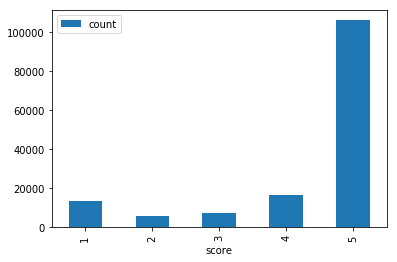




---------------------
Analyze UserId column
---------------------



top 10 users with maximum number of reviews:
+--------------+-----+
|          user|count|
+--------------+-----+
| AZV26LP92E6WU|  161|
|A281NPSIMI1C2R|   86|
|A2A8KWCE8RKB9T|   82|
|A2GEZJHBV92EVR|   70|
|A31N6KB160O508|   53|
|A35TIC6B8MVKWG|   49|
|A27NTHPTRXB766|   46|
|A3DOPYDOS49I3T|   45|
| ALL9XFM0Q1N4E|   44|
|A1KOCGNDLF2VUR|   44|
+--------------+-----+
only showing top 10 rows


 10 users with minimum number of reviews:
+--------------+-----+
|          user|count|
+--------------+-----+
|A13HKKCHHU1P5M|    1|
|A18471UYYU4JGT|    1|
|A14MSVK0CKT8Q1|    1|
|A10BENY3CHUYHC|    1|
|A14XAJMK8UK30T|    1|
|A111Y9QLUBHKNW|    1|
|A15QLSYISLDCZH|    1|
|A128K9PYRN1BYW|    1|
|A15VVGQ28FGHO1|    1|
|A12I9B47D2EBSN|    1|
+--------------+-----+
only showing top 10 rows



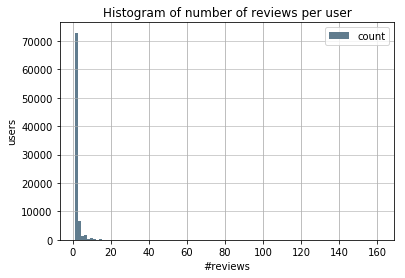




-------------------------------------
Analyze HelpfulnessDenominator column
-------------------------------------



top 10 helpfulness denominators with maximum number of reviews:
+-----------------------+-----+
|helpfulness denominator|count|
+-----------------------+-----+
|                      0|79295|
|                      1|29392|
|                      2|15217|
|                      3| 7898|
|                      4| 4941|
|                      5| 2914|
|                      6| 2281|
|                      7| 1538|
|                      8| 1011|
|                      9|  862|
+-----------------------+-----+
only showing top 10 rows


 10 helpfulness denominators with minimum number of reviews:
+-----------------------+-----+
|helpfulness denominator|count|
+-----------------------+-----+
|                     90|    1|
|                     60|    1|
|                    284|    1|
|                    452|    1|
|                     61|    1|
|                    488

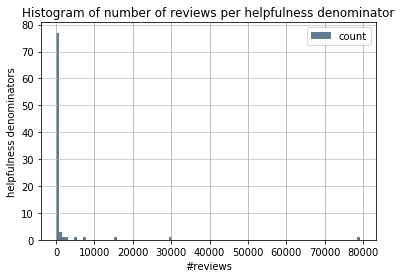




-----------------------------------
Analyze HelpfulnessNumerator column
-----------------------------------



top 10 helpfulness numerators with maximum number of reviews:
+---------------------+-----+
|helpfulness numerator|count|
+---------------------+-----+
|                    0|88594|
|                    1|30261|
|                    2|12690|
|                    3| 6404|
|                    4| 3487|
|                    5| 2116|
|                    6| 1445|
|                    7|  953|
|                    8|  661|
|                    9|  547|
+---------------------+-----+
only showing top 10 rows


 10 helpfulness numerators with minimum number of reviews:
+---------------------+-----+
|helpfulness numerator|count|
+---------------------+-----+
|                   58|    1|
|                  274|    1|
|                  193|    1|
|                   71|    1|
|                  466|    1|
|                   77|    1|
|                   55|    1|
|                 

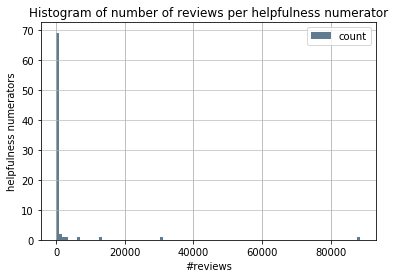




------------------------
Analyze ProductId column
------------------------



top 10 products with maximum number of reviews:
+----------+-----+
|   product|count|
+----------+-----+
|B007JFMH8M|  401|
|B0026RQTGE|  234|
|B002QWHJOU|  234|
|B002QWP89S|  234|
|B002QWP8H0|  234|
|B005K4Q34S|  215|
|B005K4Q4LK|  215|
|B005K4Q1YA|  215|
|B005K4Q37A|  215|
|B0013A0QXC|  171|
+----------+-----+
only showing top 10 rows


 10 products with minimum number of reviews:
+----------+-----+
|   product|count|
+----------+-----+
|B000FRZBXE|    1|
|B000NTZ3IW|    1|
|B000HDMUKS|    1|
|B0001UQWRY|    1|
|B000ILMQLM|    1|
|B0006MU99E|    1|
|B000JSO2AM|    1|
|B000E5C59U|    1|
|B000KHVHG4|    1|
|B000FA157W|    1|
+----------+-----+
only showing top 10 rows



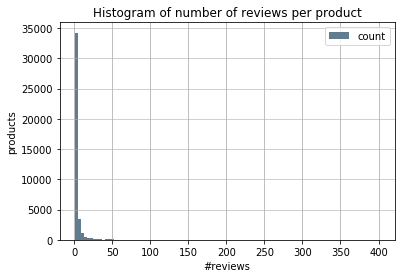

In [6]:
displaySubTitle("Task3.b")
print("Create histogram to analayze the distribution of the selected columns")

# Get aggregated data frame of a given column, and the suitable count.
# Parameters:
# df - data frame
# columnName - name of column to aggregate
# columnAlias - alternative name of the columnName
# Returns:
# aggregated data frame, with 2 columns: alias column, and the suitable count frequiencies column.
def getAggregatedDfCount(df, columnName, columnAlias):
    return df.groupBy(columnName).agg(F.size(F.collect_list(columnName))).select(col(columnName).alias(columnAlias), col("size(collect_list(" + columnName + "))").alias("count"))

# Analyze column which contains continueous values, and display a histogram.
# aggregated_df - data frame with 2 columns: column and column count.
# pandas_df - aggregated_df converted to pandas dataframe.
# columnName - name of column to analyze, in aggregated_df
# columnAlias - name of column to analyze, in columnAlias
# recordName - name of record, which represents the original rows in aggregated_df
# numOfBins - number of bins to display in the histogram
def analyzeContinuousValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBins):
    
    # Show top records with highest frequencies.
    print("\ntop " + repr(numOfTopRecords) + " " + columnAlias + "s with maximum number of " + recordName + "s:")
    aggregated_df.orderBy("count", ascending=False).show(numOfTopRecords)
    
    # Show top records with lowest frequencies.
    print("\n " + repr(numOfTopRecords) + " " + columnAlias + "s with minimum number of " + recordName + "s:")
    aggregated_df.orderBy("count").show(numOfTopRecords)

    # Create histogram plot.
    pandas_df.plot.hist(grid=True, bins=numOfBins, rwidth=1, color='#607c8e')
    plt.title('Products reviews')
    plt.xlabel("#" + recordName + "s")
    plt.ylabel(columnAlias + "s")
    plt.title("Histogram of number of " + recordName + "s per " + columnAlias)
    plt.grid(axis='y', alpha=0.75)
    
    # Plot histogram.
    plt.show()
    
# Analyze column which contains descrete values, and display a bar graph.
# aggregated_df - data frame with 2 columns: column and column count.
# pandas_df - aggregated_df converted to pandas dataframe.
# columnName - name of column to analyze, in aggregated_df
# columnAlias - name of column to analyze, in columnAlias
# recordName - name of record, which represents the original rows in aggregated_df
# numOfBins - number of bins to display in the bar graph
def analyzeDescreteValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBins):   
    # Force convertion of alias column to int type, if conversion fails - don't throw erroes
    pandas_df[columnAlias] = pd.to_numeric(pandas_df[columnAlias], errors='coerce').astype(int)
    
    # Sort alias column in descending order.
    pandas_df.sort_values(by=[columnAlias], inplace=True)
    
    # Remove index column (for diaplay purposes)
    blankIndex=[''] * len(pandas_df)
    pandas_df.index=blankIndex
    
    # Display frequncies of alias column.
    display(pandas_df.nlargest(numOfBins,columns=columnAlias))
    
    # Create bar plot
    pandas_df.plot(kind='bar',x=columnAlias,y='count')
    
    # Plot bar graph
    plt.show()

# Analyze column values frequencies, and plot the results.
# Parameters:
# df - dataframe
# columnName - name of column in df to analyze
# columnAlias - alternative name of the columnName. Will be used for display purposes.
# recordName - name of record, which represents the original rows in df
# columnType - 0 - for descrete values, 1 - for continuous values
def analyzeColumn(df, columnName, columnAlias, recordName, columnType):
    displayTitle("Analyze " +  columnName + " column")
    
    # group df by columnName as columnAlias.
    aggregated_df = getAggregatedDfCount(df, columnName, columnAlias)
    
    # Convert df to pandas data frame.
    pandas_df = aggregated_df.toPandas()
    
    # Check if current column contains descrere values or continueous values 
    if columnType == 0: # descrete values column
        #  analyze descrete column & plot bar graph
        analyzeDescreteValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, columnCountDict[columnName])
    else: # columnType == 1 ==> continuous values column
        #  analyze continuous column & plot histogram
        analyzeContinuousValueColumn(aggregated_df, pandas_df, columnName, columnAlias, recordName, numOfBinsInHistogramOfContinueosValues)
    
    # Release unused memory
    del pandas_df

print("get reviews rdd")
reviews_rdd = reviews.map(lambda line: line.split(","))

print("get reviews data frame")
reviews_df = reviews_rdd.toDF(columnsTitles)        

# Define dinctionary of 5 selected columns and their matching value type: 0 for descrete value, 1 for continuous value
selectedColumnTypeDict = {'ProductId':1, 'UserId':1, 'HelpfulnessNumerator':1, 'HelpfulnessDenominator':1, 'Score':0}

print("Analyze selected columns & Display results\n")
for column in selectedColumns:
    analyzeColumn(reviews_df, column, selectedColumnsTitleDict[column], 'review', selectedColumnTypeDict[column])
    # print separator, for distinuishing between current column analysis results, and the previos column.
    print("\n==========================================================================================================")
    
plt.close() # close plot, for data leak prevention

In [7]:
displaySubTitle("Task3.c")
print("Explain the results of previous tasks:\n")
'''

----------------
1. Score column:
----------------
Since this column contains descrete values (1-5), It has been plotted on a bar plot.

There are 5 distinct scores
106054 reviews have been ranked as '5 stars'.
16691 reviews have been ranked as '4 stars'.
7309 reviews have been ranked as '3 stars'.
5928 reviews have been ranked as '2 stars'.
13406 reviews have been ranked as '1 stars'.

Number of filtered records is 149388
Total number of reviews is 106054 + 16691 + 7309 + 5928 + 13406 = 149388
Therefore there are no reviews with  0 stars

-------------------------------------------------------------------------------
2. The columns: ProductId, UserId, HelpfulnessNumerator, HelpfulnessDenominator
-------------------------------------------------------------------------------
Since these columns contains continueous values, It has been plotted on a histogram plot.

for each of these columns.
The frequency has been calculated.

So we get for each product|user|helpfulness numerator|helpfulness denominator, the number of relevant reviews.

    2.1 ProductId column:
    -------------------------

    The most popular product is B007JFMH8M, with 401 reviews.
    The are many unpopular products, For example: B000EMK4JQ has only a single review.

    From the products-reviews histogram we can conclude that most of the products have received less than 50 reviews.

    
    2.2 UserId column:
    ----------------------

    The most popular user is AZV26LP92E6WU, who posted with 161 reviews.
    Most of the users posted only a single review. For example: A13HKKCHHU1P5M has posted only a single review.

    From the users-reviews histogram we can conclude that most of the users have posted only a single review.
    
    2.3 HelpfulnessNumerator column:
    --------------------------------
    88594 reviews, have not been indicated by the users as helpful.
    Just a few of the reviews have been indicated as helpful by many users. For example there is a review that has been indicated as helpful by 466 users.

    From the users-reviews histogram we can conclude that most of the reviews were indicated as not helpful by the users.


    2.4 HelpfulnessDenominator column:
    ----------------------------------
    79295 reviews, have not been indicated by the users as helpful or not helpful.
    Just a few of the reviews have been indicated as helpful or not helpful by many users. For example there is a review that has been indicated by 488 users.

    From the users-reviews histogram we can conclude that most of the reviews were not indicated by the users.

'''
print("Task3- done")



Task3.c
-------


Explain the results of previous tasks:

Task3- done


In [8]:
displayTitle("Task4:")
print("-------------------------------------------------------------\n")
print("4.a - Fill in bad or missing values")
print("4.b - Explain the strategy for Filling in bad or missing values")
print("-------------------------------------------------------------\n")

displaySubTitle("Task4.a")
print("Fill in bad or missing values:\n")

# Get max values count extracted from the suitble columns in columnCountRddList
def getMaxValuesCountForColumns(columnsForFillingMaxValues):
    maxValues = []
    # For each column from the list columnsForFillingMaxValues,
    # get the most common value (the max value)
    # This value will be used as a replacement value in the relevant column, in case of missing values
    for column in columnsForFillingMaxValues:
        maxValue = columnCountRddList[selectedColumns.index(column)].max(lambda x: x[1])[0]
        maxValues.append(int(maxValue))
    return maxValues

# Check is a given value is defined as 'missing value'
def isMissingValue(value):
    # define the values that will be evaluated as missing values.
    missing_values = ["n/a", "N/A", "na", "NA", "NaN", "NAN", "--", ""]
    return value is None or len(value) == 0 or value in missing_values

# Get the replaced value if missing value is detected.
def replaceValueIfMissing(x, index):
    value = x[index]
    if isMissingValue(value):
        isMissingValuesFound = True
        return missingValuesMapPolicy(x,index)
    else:
        return value

# switch case with implementation of missing values replacement strategy.
def missingValuesMapPolicy(x, index):
    switcher = { 
        0: repr(hash(tuple(x))), # replace missing id with hash code of the entire row.
        4: maxValues[0], # replace missing helpfulness numerator with the maximum count value
        5: maxValues[1], # replace missing helpfulness denominator with the maximum count value
        6: maxValues[2], # replace missing score with the maximum count value
        7: repr(random.randint(minMaxTime[0], minMaxTime[1])) # replace missing time stamp with random timestamp in range between minimal and maximal time values.
    }
    return switcher.get(index, x[index]) # Get switcher value, or x[index], if switcher does not contain the index key.
                             
# Map rdd entries with the transformed missing values of the columns: helpfulnessDenominator, helpfulnessNumerator to the suitable count max values                          
def mapMissingValues(x):
    idValue = replaceValueIfMissing(x,columnsDict['Id'])
    helpfulnessNumeratorValue = replaceValueIfMissing(x,columnsDict['HelpfulnessNumerator'])
    helpfulnessDenominatorValue = replaceValueIfMissing(x,columnsDict['HelpfulnessDenominator'])
    scoreValue = replaceValueIfMissing(x,columnsDict['Score'])
    timeValue = replaceValueIfMissing(x,columnsDict['Time'])
    return (idValue, x[1], x[2], x[3], helpfulnessNumeratorValue, helpfulnessDenominatorValue, scoreValue, timeValue, x[8], x[9])


isMissingValuesFound = False

# Append most common values of the columns: 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score' to maxValues list
potentialColumnsForFillingMaxValues = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score']
maxValues = getMaxValuesCountForColumns(potentialColumnsForFillingMaxValues)

# Extract min time & max time, for filling out missing time values.
timeIndex = columnsDict['Time']
minMaxTime = getMinMax(reviews_rdd, timeIndex)

# Map mising values (if missing values exists)
reviews_rdd = reviews_rdd.map(lambda x: mapMissingValues(x))

# Display missing values analysis results.
if isMissingValuesFound:
    print("Missing values have been replaced by the most common relevant values.")
    print("Displaying top " + repr(minimalNumOfTopRecords) + " rows")
    reviews_rdd.take(minimalNumOfTopRecords)
else:
    print('Missing values were not detected')




------
Task4:
------


-------------------------------------------------------------

4.a - Fill in bad or missing values
4.b - Explain the strategy for Filling in bad or missing values
-------------------------------------------------------------



Task4.a
-------


Fill in bad or missing values:

Missing values were not detected


In [9]:
displaySubTitle("Task4.b")
print("Explain the strategy for Filling in bad or missing values:\n")
'''
The Filling in bad or missing values strategy:
----------------------------------------------

1. In case of numeric values (relevant for the columns: 'Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator'):
The minimal impact on a row, will be achived by filling the most common value of a given rdd pair.

For example:
in case of the score column, this is the relevant rdd pair [score -> count]:
5 	106054
4 	16691
3 	7309
2 	5928
1 	13406

We can observe, that the most common value (maximum value) is score 5 (with 106054 records).
Therefore if a score is missing in some record, we need to replace it with the value '5'

2. In case of identifier unique column (relevant for the 'Id' column):
If a unique value is missing, than instead of the missing unique value, we have to generate a unique value for the row.
We can do it by using the hash code of the row.

3. In case of timestamp column (relevant for the 'Time' column):
If  a timestamp is missing, than we have to generate an alternative timestamp in range of the minimum timestamp and the maximum timestamp.

4. In case of textual column (relevant for the columns: 'Summary','Text'):
Missing textual values are irrelevant, since we cannot invent an alternative text that will have a logical fit.
Therefore empty text will remain empty.

5. In case of general identifier column (relevant for the columns: 'ProductId', 'UserId', 'ProfileName'):
missing identifier column cannot be recovered. It leads to a corrupted data.
We can skip this data or filter it out.
For example, if product id is missing , than there is no way to invent some product id, as areplacement value.


'''
print("Task4- done")



Task4.b
-------


Explain the strategy for Filling in bad or missing values:

Task4- done


In [10]:
displayTitle("Task5")
print("Transform 2 columns which contains categorical features to numerical values:\n")
print("Since there are no categorical columns in the dataset, we will consider the columns: HelpfulnessNumerator, HelpfulnessDenominator as categorical, by partition these columns to different ranges.")

# Convert continueous value to numeric category
# Most of the entries in the data are less than 2
# Therefore 0 will be mapped to 0, and 1 will be mapped to 1
# The rest of the values will be mapped according to their suitable length + 1
def getCategory(value):
    if value < 2:
        return value
    return len(str(value)) + 1

# Extract map with categories, from rdd pair
def convertRddPairToMapWithCategories(rddPair):
    return rddPair.map(lambda x: (int(x[0]), x[1])).map(lambda x: (x[0],getCategory(x[0]))).collectAsMap()

# Create the desired mapping between a category and the corespponding value.
helpfulnessNumeratorCountMap = convertRddPairToMapWithCategories(columnCountRddList[selectedColumns.index('HelpfulnessNumerator')])
helpfulnessDenominatorCountMap = convertRddPairToMapWithCategories(columnCountRddList[selectedColumns.index('HelpfulnessDenominator')])

# Map rdd entries with the transformed categories of the columns: helpfulnessDenominator, helpfulnessNumerator
def mapWithCategories(x):
    if type(x[columnsDict['HelpfulnessNumerator']]) == str and type(x[columnsDict['HelpfulnessDenominator']]) == str and type(x[columnsDict['Time']]) == str: # Map to numerical values, only if the values are not already mapped.
        return (x[0], x[1], x[2], x[3], helpfulnessNumeratorCountMap[int(x[columnsDict['HelpfulnessNumerator']])], helpfulnessDenominatorCountMap[int(x[columnsDict['HelpfulnessDenominator']])], int(x[6]), x[7], x[8], x[9])
    else:
        return x

print("\nPerfoem rdd mapping of 2 categories for the columns: helpfulnessDenominator, helpfulnessNumerator")
reviews_rdd_with_2_categorical_columns = reviews_rdd.map(lambda x: mapWithCategories(x))

print("\nDisplay top " + repr(minimalNumOfTopRecords) + " records after mapping 2 columns to numericc categorical features\n")
print(reviews_rdd_with_2_categorical_columns.take(minimalNumOfTopRecords))

print("\nTask5- done")



-----
Task5
-----


Transform 2 columns which contains categorical features to numerical values:

Since there are no categorical columns in the dataset, we will consider the columns: HelpfulnessNumerator, HelpfulnessDenominator as categorical, by partition these columns to different ranges.

Perfoem rdd mapping of 2 categories for the columns: helpfulnessDenominator, helpfulnessNumerator

Display top 3 records after mapping 2 columns to numericc categorical features

[('1', 'B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', 1, 1, 5, '1303862400', 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'), ('2', 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', 0, 0, 1, '1346976000', 'Not as Advertised', '"Product arrived labeled as Jumbo Salted Peanuts...the peanuts w

In [11]:
displayTitle("Task6")
print("Transform the timestamp column into categorical features: year, month, day, hour:\n")

# Convert timestamp in string format, to datetime object
def getTime(timestamp):
    print("Timestamp: " + repr(timestamp))
    return datetime.fromtimestamp(float(timestamp))

# Map row with timestamp, to row with time as categorical features: year, month, day, hour
def mapTimestamp(x, timeIndex):
    if(len(x) == numOfColumns): # map timestamp, only if it's not mapped yet.
        t = getTime(x[timeIndex])
        return (x[0], x[1], x[2], x[3], x[4], x[5], x[6], t.year, t.month, t.day, t.hour, x[8], x[9])
    else:
        return x

timeIndex = columnsDict['Time']
reviews_rdd = reviews_rdd.map(lambda x: mapTimestamp(x, timeIndex))

print("\nDisplay top 3 records after converting timestamp to the columns: year, month, day, hour\n")
print(reviews_rdd.take(3))

print("\nTask6- done")



-----
Task6
-----


Transform the timestamp column into categorical features: year, month, day, hour:


Display top 3 records after converting timestamp to the columns: year, month, day, hour

[('1', 'B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', '1', '1', '5', 2011, 4, 26, 17, 'Good Quality Dog Food', 'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'), ('2', 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', '0', '0', '1', 2012, 9, 6, 17, 'Not as Advertised', '"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."'), ('4', 'B000UA0QIQ', 'A395BORC6FGVXV', 'Karl', '3', '3', '2', 2011, 6, 12, 17, 'Cough Medicine', 'If you are looking for the secr

In [12]:
displayTitle("Task7")
print("Normalizing 2 selected columns:")

# Check if a given column rdd is normally distributed, using the Kolmogorov-Smirnov method
# For more details, check this link: https://www.spss-tutorials.com/spss-kolmogorov-smirnov-test-for-normality/
def isNormalyDistributed(columnRdd):
    valuesList = columnRdd.collect()
    statistic, pvalue = kstest(valuesList, lambda x: x)
    print("pvalue = " + str(pvalue) + ", statistic = " + str(statistic))
    return pvalue >= 0.05 # reject the null hypothesis if p < 0.05

# Get standardize value, using the zscore method. (normal standardization)
# Parameters:
# - value: original value
# - meann: maen value
# return: standardized value
def zScoreStandardize(value, mean, std):
    return (value - mean) / std

# Get normalized value, using the min-max method.
# Parameters:
# - value: original value
# - min: minimum value
# - max: maximum value
# return: normalized value
def minMaxNormalize(value, min, max):
    if min == 0 and max == 1: # Normalize value, only if it's not already normalized.
        return value
    else:
        return (value - min) / (max - min)

# normalie value, using min-max normalization or zscore normal standardization.
# Parameters:
# - value: original value
# - arg1: minimum value - if normalizationType = 0, mean - if normalizationType = 1
# - arg2: maximum value - if normalizationType = 0, stdev - if normalizationType = 1
# - normalizationType: 0 - for min-max normalization, 1- for zscore normal standardization
# return: normalized value
def normalize(value, arg1, arg2, normalizationType):
    print("value=" + repr(value) + ", arg1=" + repr(arg1) + ", arg2= " + repr(arg2))
    if normalizationType == 0:
        return minMaxNormalize(value, arg1, arg2)
    else:
        return zScoreStandardize(value, arg1, arg2)

# Map rdd entries with the transformed mormalized columns: helpfulnessDenominator, helpfulnessNumerator
def mapWithNormalization(x):
    numeratorArg1  = params['HelpfulnessNumerator'][0]
    numeratorArg2  = params['HelpfulnessNumerator'][1]
    denominatorArg1 = params['HelpfulnessDenominator'][0]
    denominatorArg2 = params['HelpfulnessDenominator'][1]
    normalizedNumerator = normalize(int(x[4]), numeratorArg1, numeratorArg2, normalizationMethods[0])
    normalizedDenominator = normalize(int(x[5]), denominatorArg1, denominatorArg2, normalizationMethods[1])
    return (x[0], x[1], x[2], x[3], normalizedNumerator, normalizedDenominator, int(x[6]), x[7], x[8], x[9])
                         
# define list of columns to normalize.
columnsToNormalize = ['HelpfulnessNumerator', 'HelpfulnessDenominator']
strColumnsToNormalize = ', '.join(columnsToNormalize)
print(strColumnsToNormalize + "\n")

normalizationMethods = [] # 0 - for min max normalization, 1 - for zscore standardization
params = {} #Dictionary of tuple elements: key is column name, value is : (min value, max value) - in case of normalization. (mean, stdev) - in case of standardization

# For each column in columnsToNormalize list:
# - Check if values should be normalized (using min-max method) or standardized (using zscore method)
# - Append normalization method to normalizationMethods list: 1 - in case of normalization, 0 - in case of standadization.
# - Append normalization parameters to params list: (min,max) in case of normalization. (mean, stdev) in case of standadization.
for column in columnsToNormalize:
    columnIndex = columnsDict[column]
    columnRdd = reviews_rdd.map(lambda x: int(x[columnIndex]))
    print("Check if " + column + " is normally distributed...")
    if isNormalyDistributed(columnRdd):
        print(column + " is normally distributed")
        print("Extract mean & stdev values of the column " + column + ", in order to  for standardize values...")
        normalizationMethods.append(1)
        params[column] = (columnRdd.mean(), columnRdd.stdev())
    else:
        print(column + " is not normally distributed")
        print("Extract min & max values of the column " + column + ", in order to normalize values...")
        normalizationMethods.append(0)
        params[column] = getMinMax(reviews_rdd, columnIndex)

# Normalize rdd columns in columnsToNormalize list
print("Normalize the columns: " + strColumnsToNormalize + " ...")
reviews_rdd_with_2_normalized_columns = reviews_rdd.map(lambda x: mapWithNormalization(x))

print("\nDisplay top " + repr(minimalNumOfTopRecords) + " records after normalizing the columns: " + strColumnsToNormalize + "\n")
print(reviews_rdd_with_2_normalized_columns.take(minimalNumOfTopRecords))

print("\nTask7- done")



-----
Task7
-----


Normalizing 2 selected columns:
HelpfulnessNumerator, HelpfulnessDenominator

Check if HelpfulnessNumerator is normally distributed...
pvalue = 0.0, statistic = 465.0000066939781
HelpfulnessNumerator is not normally distributed
Extract min & max values of the column HelpfulnessNumerator, in order to normalize values...
Check if HelpfulnessDenominator is normally distributed...
pvalue = 0.0, statistic = 487.0000066939781
HelpfulnessDenominator is not normally distributed
Extract min & max values of the column HelpfulnessDenominator, in order to normalize values...
Normalize the columns: HelpfulnessNumerator, HelpfulnessDenominator ...

Display top 3 records after normalizing the columns: HelpfulnessNumerator, HelpfulnessDenominator

[('1', 'B001E4KFG0', 'A3SGXH7AUHU8GW', 'delmartian', 0.002145922746781116, 0.0020491803278688526, 5, 2011, 4, 26), ('2', 'B00813GRG4', 'A1D87F6ZCVE5NK', 'dll pa', 0.0, 0.0, 1, 2012, 9, 6), ('4', 'B000UA0QIQ', 'A395BORC6FGVXV', 'Karl', 0

In [13]:
displayTitle("Task8")
print("----------------------------------------------------------------\n")
print("Perform the following transformations to the text column: 'Text'\n")
print("8.a - Tokenization")
print("8.b - Stop word removal")
print("8.b - binary vectorization")
print("----------------------------------------------------------------\n")

displaySubTitle("Task8.a")
print("Tokenization:\n")

# define tokenizer, with words pattern
regexTokenizer = RegexTokenizer(inputCol="Text", outputCol="words", pattern="\\W")

# define tokens counter.
countTokens = udf(lambda words: len(words), IntegerType())

# Tokenize reviews_df
regexTokenized = regexTokenizer.transform(reviews_df)

# Select the tokenized Text column
tokenizedData = regexTokenized.select("Text", "words").withColumn("tokens", countTokens(col("words")))

print("Display results:")
print("Every row's results will be displayed in the following format: |Text|words|tokens|")
regexTokenized.show(truncate=False)



-----
Task8
-----


----------------------------------------------------------------

Perform the following transformations to the text column: 'Text'

8.a - Tokenization
8.b - Stop word removal
8.b - binary vectorization
----------------------------------------------------------------



Task8.a
-------


Tokenization:

Display results:
Every row's results will be displayed in the following format: |Text|words|tokens|
+---+----------+--------------+---------------------------+--------------------+----------------------+-----+----------+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
displaySubTitle("Task8.b")
print("Stop word removal:\n")

print("Get list of stop words to be removed, using StopWordsRemover")
listOfWords = StopWordsRemover.loadDefaultStopWords("english")

print("Define remover, with the list of stop words that have been loaded")
remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=listOfWords)

print("Remove stop words")
cleanData = remover.transform(tokenizedData)

print("Display results, after removing stop words")
print("Every row's results will be displayed in the following format: |Text|words|tokens|filtered|")
cleanData.show()



Task8.b
-------


Stop word removal:

Get list of stop words to be removed, using StopWordsRemover
Define remover, with the list of stop words that have been loaded
Remove stop words
Display results, after removing stop words
Every row's results will be displayed in the following format: |Text|words|tokens|filtered|
+--------------------+--------------------+------+--------------------+
|                Text|               words|tokens|            filtered|
+--------------------+--------------------+------+--------------------+
|I have bought sev...|[i, have, bought,...|    48|[bought, several,...|
|"Product arrived ...|[product, arrived...|    32|[product, arrived...|
|If you are lookin...|[if, you, are, lo...|    41|[looking, secret,...|
|Right now I'm mos...|[right, now, i, m...|    27|[right, m, mostly...|
|This is a very he...|[this, is, a, ver...|    25|[healthy, dog, fo...|
|good flavor! thes...|[good, flavor, th...|    15|[good, flavor, ca...|
|The Strawberry Tw...|[the, stra

In [15]:
displaySubTitle("Task8.c")
print("Binary vectorization of Text column:\n")

print("Fetch filtered words (after tokenization and stop words removal) ...")
filteredWords =  cleanData.select('filtered')
print(filteredWords.take(10))

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Convert data frmae to pandas in chuncks of deserialized memory.
filteredWordsPandas = filteredWords.toPandas()

# Fetch words list from the converted pandas data frame
filteredWordsList = filteredWordsPandas.values

print("Extract list of words from filtered words")
finalWordsList = []
for item in filteredWordsList:
    finalWordsList.append(item[0])

print("Create sparse binary matrix from list of words")
def dummy(doc):
    return doc

cv = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    binary=True
)  

Xe = cv.fit_transform(finalWordsList)
print(Xe)

print("\nTask8- done")



Task8.c
-------


Binary vectorization of Text column:

Fetch filtered words (after tokenization and stop words removal) ...
[Row(filtered=['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']), Row(filtered=['product', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'sure', 'error', 'vendor', 'intended', 'represent', 'product', 'jumbo']), Row(filtered=['looking', 'secret', 'ingredient', 'robitussin', 'believe', 'found', 'got', 'addition', 'root', 'beer', 'extract', 'ordered', 'good', 'made', 'cherry', 'soda', 'flavor', 'medicinal']), Row(filtered=['right', 'm', 'mostly', 'sprouting', 'cats', 'eat', 'grass', 'love', 'rotate', 'around', 'wheatgrass', 'rye']), Row(filtered=['healthy', 'dog', 'food', 'good', 'digestion', 'also', 'good', 'small', 'puppie

/home/zorik/.local/lib/python3.5/site-packages/pyarrow/__init__.py:159: UserWarning: pyarrow.open_stream is deprecated, please use pyarrow.ipc.open_stream
  warnings.warn("pyarrow.open_stream is deprecated, please use "


Extract list of words from filtered words
Create sparse binary matrix from list of words
  (0, 2928)	1
  (0, 14957)	1
  (0, 21310)	1
  (0, 4911)	1
  (0, 34110)	1
  (0, 23381)	1
  (0, 29090)	1
  (0, 35438)	1
  (0, 21909)	1
  (0, 22289)	1
  (0, 29133)	1
  (0, 29726)	1
  (0, 16831)	1
  (0, 15587)	1
  (0, 29145)	1
  (0, 15438)	1
  (0, 12228)	1
  (0, 6778)	1
  (0, 40013)	1
  (0, 33116)	1
  (0, 5675)	1
  (1, 31047)	1
  (1, 19784)	1
  (1, 39725)	1
  (1, 13665)	1
  :	:
  (149386, 7735)	1
  (149386, 22395)	1
  (149386, 39420)	1
  (149386, 14932)	1
  (149386, 17159)	1
  (149386, 4911)	1
  (149386, 16831)	1
  (149387, 17326)	1
  (149387, 12236)	1
  (149387, 31401)	1
  (149387, 25436)	1
  (149387, 22423)	1
  (149387, 38201)	1
  (149387, 28606)	1
  (149387, 38302)	1
  (149387, 32874)	1
  (149387, 6660)	1
  (149387, 14613)	1
  (149387, 38311)	1
  (149387, 22395)	1
  (149387, 40602)	1
  (149387, 4890)	1
  (149387, 36464)	1
  (149387, 16831)	1
  (149387, 12228)	1

Task8- done
